#**Convolution layer and pooling**

This notebook provides a concrete demonstration of how convolutional layers work. The goal is to give you a deeper understanding of this very useful operation.

See the [*convolutional arithmetic*](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) article by Vincent Dumoulin and Francesco Visin for detailed explanations of how convolutions can be configured, and how different configurations are used. (Image credit: Dumoulin & Visin)

*Note:* The code cells re-use variable name `x`, so they must be run in the order presented. This is not a best practice for notebooks but is used to keep variable names simple in this demo.

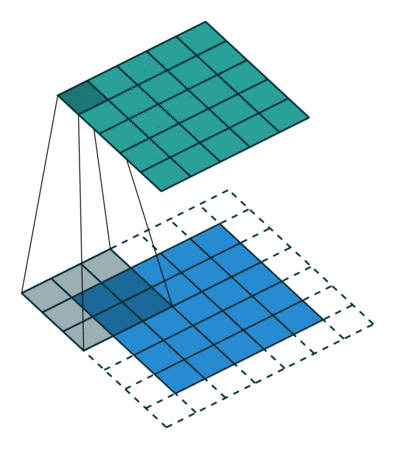

In [ ]:
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import torch

## **Create synthetic image**

In [ ]:
def make_synthetic():
    x = np.zeros((10, 12), dtype=np.float32)
    x[2:5,2:5] = -1
    x[4:8,4:10] = +1
    return x

x = make_synthetic()
x

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
      dtype=float32)

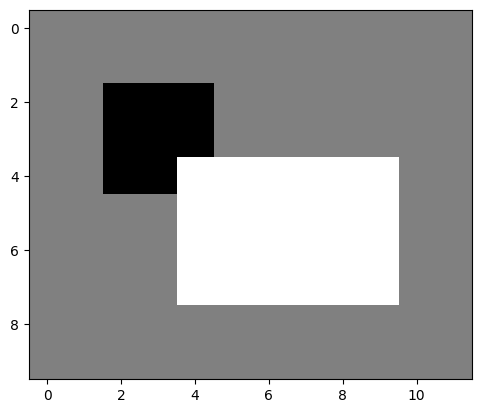

In [ ]:
plt.imshow(x, cmap='gray');

## **Convolution implemented in Python**

In [ ]:
def conv_py(x, w):
    """Convolution of a single 2D input x with a single filter w, both in (H,W) format."""
    xn, xm = x.shape
    wn, wm = w.shape
    an, am = (xn-wn+1, xm-wm+1)         # size of output feature map
    a = np.zeros((an, am), dtype=np.float32)
    for ai in range(an):                # loop over output row ai
        for aj in range(am):            # loop over output col aj
            for wi in range(wn):        # loop over filter row wi
                for wj in range(wm):    # loop over filter col wj
                    xi = ai + wi        # calculate input row xi
                    xj = aj + wj        # calculate input col xj
                    a[ai,aj] += w[wi,wj] * x[xi,xj]  # contribute x[xi,xj] to a[ai,aj]
    return a

Define a "vertical edge detector" pattern as an example

In [ ]:
w = np.array([[-1, +1],
              [-1, +1]], dtype=np.float32)

Convolve synthetic image with the "vertical-edge detector" filter

In [ ]:
a = conv_py(x, w)
a.shape

(9, 11)

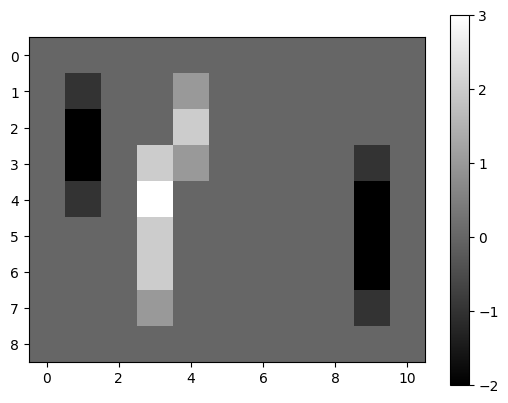

In [ ]:
plt.imshow(a, cmap='gray'); plt.colorbar();

## **Convert image from (H,W) format to (N,C,H,W) format for PyTorch**

* Matplotlib expects (height, width[, num_channels]) format tensors.
* PyTorch expects (batch_size, num_channels, height, width) format tensors.

In [ ]:
def hwc_to_nchw(x):
    """Convert x from (H,W[,C]) to (N,C,H,W) format where N=1."""
    if x.ndim < 3:
        x = x.unsqueeze(2)
    return x.permute(2, 0, 1).unsqueeze(0)

In [ ]:
print("before:", type(x), x.shape)
x = hwc_to_nchw(torch.from_numpy(x))
print("after: ", type(x), x.shape)

before: <class 'numpy.ndarray'> (10, 12)
after:  <class 'torch.Tensor'> torch.Size([1, 1, 10, 12])


## **Convolution in PyTorch**

In [ ]:
torch.manual_seed(0);  # Ensure PyTorch uses same random initial weights

conv = torch.nn.Conv2d(in_channels=1, out_channels=2, kernel_size=2, stride=1, padding=0)

PyTorch convolution weights organized as *weight[out_channel, in_channel, filter_row, filter_col]* and *bias[out_channel]*

In [ ]:
print("parameter weights:", type(conv.weight), conv.weight.shape)
print("parameter biases: ", type(conv.bias), conv.bias.shape)

parameter weights: <class 'torch.nn.parameter.Parameter'> torch.Size([2, 1, 2, 2])
parameter biases:  <class 'torch.nn.parameter.Parameter'> torch.Size([2])


In [ ]:
conv.weight

Parameter containing:
tensor([[[[-0.0037,  0.2682],
          [-0.4115, -0.3680]]],


        [[[-0.1926,  0.1341],
          [-0.0099,  0.3964]]]], requires_grad=True)

In [ ]:
conv.bias

Parameter containing:
tensor([-0.0444,  0.1323], requires_grad=True)

## **Convolve with random weights**

In [ ]:
a = conv(x)
print("activation map:", a.shape)      # (N,C,H,W) format

activation map: torch.Size([1, 2, 9, 11])


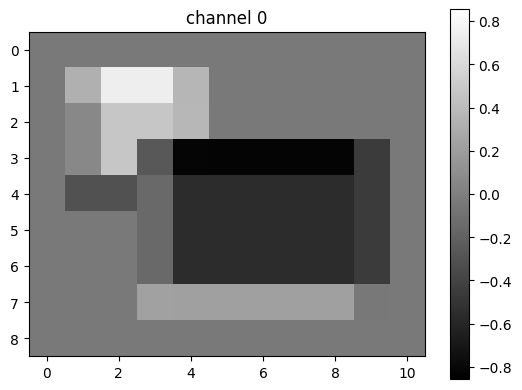

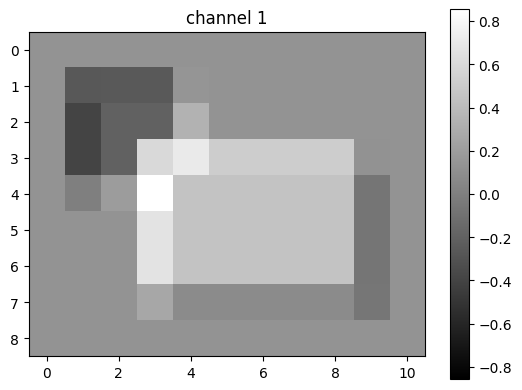

In [ ]:
def plot_channels(x, **kwargs):
    """Plot each channel in z as an image, where z is in (C,H,W) format."""
    vmax = max(-x.min(), x.max())   # Range of values
    for i, channel in enumerate(x):
        plt.figure(**kwargs);
        plt.imshow(channel.detach(), vmin=-vmax, vmax=vmax, cmap='gray');
        plt.colorbar();
        plt.title("channel %d" % i)

plot_channels(a[0])

## **Convolve with hand-crafted parameters**

Set filter 0 to be vertical edge detector, filter 1 to be horizontal edge detector.

In [ ]:
conv.weight.data[0,:] = torch.tensor([[[-1, +1],
                                       [-1, +1]]])

conv.weight.data[1,:] = torch.tensor([[[-1, -1],
                                       [+1, +1]]])

conv.bias.data[:] = 0

In [113]:
conv.weight

Parameter containing:
tensor([[[[-0.0037,  0.2682],
          [-0.4115, -0.3680]]],


        [[[-0.1926,  0.1341],
          [-0.0099,  0.3964]]]], requires_grad=True)

In [114]:
conv.bias

Parameter containing:
tensor([-0.0444,  0.1323], requires_grad=True)

Show the resulting activation maps for our synthetic image

tensor(0.8554, grad_fn=<MaxBackward1>)


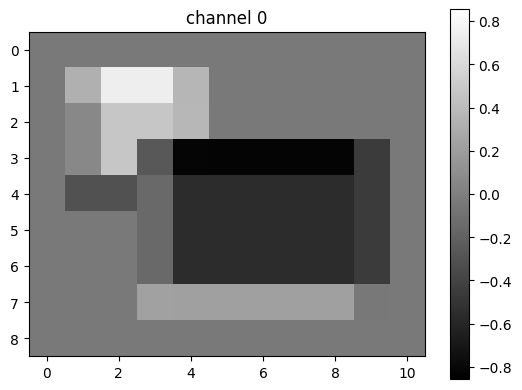

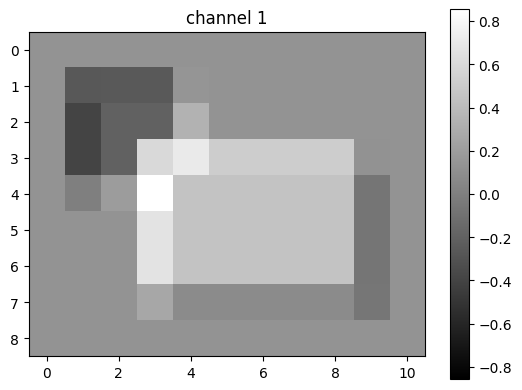

In [115]:
a = conv(x)
plot_channels(a[0])

## **Plot feature maps**

By applying a non-linearity such as ReLU, we turn activation maps into feature maps.

In [117]:
func = torch.nn.ReLU()

tensor(0.8554, grad_fn=<MaxBackward1>)


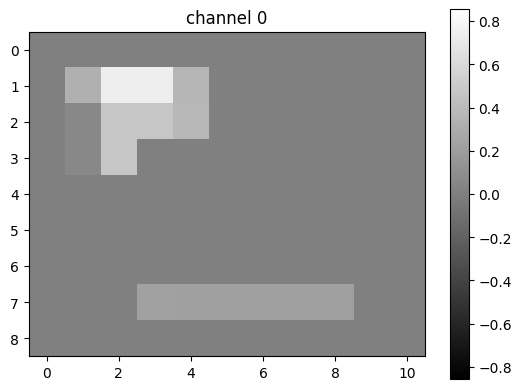

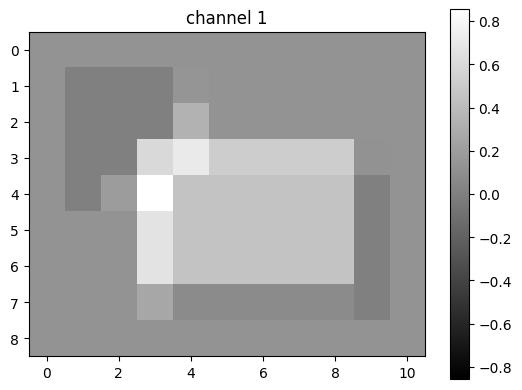

In [118]:
z = func(a)
plot_channels(z[0])

## **Convolve on real image**

Let's download a real image:

In [119]:
!gdown 11_0HrPXch92SDQIdlyXP6nGVDp6-U_ys

Downloading...
From: https://drive.google.com/uc?id=11_0HrPXch92SDQIdlyXP6nGVDp6-U_ys
To: /content/convolution_layer_demo.png
100% 27.0k/27.0k [00:00<00:00, 48.5MB/s]


torch.Size([130, 300])

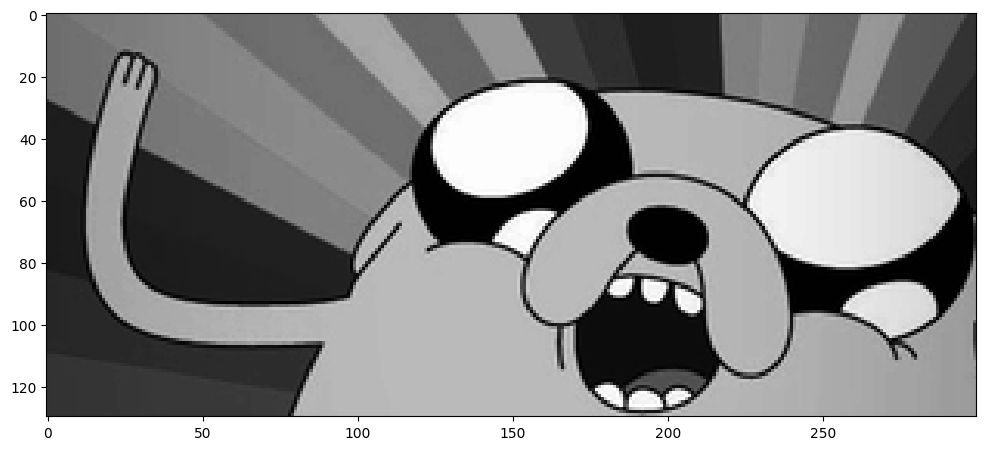

In [125]:
def load_example():
    x = plt.imread('convolution_layer_demo.png')
    return torch.from_numpy(x)

x = load_example()
plt.figure(figsize=(12,24))
plt.imshow(x, cmap='gray');
x.shape

In [126]:
x = hwc_to_nchw(x)
x.shape

torch.Size([1, 1, 130, 300])

Compute activation map using our two 2x2 filters from earlier

tensor(0.7672, grad_fn=<NegBackward0>)


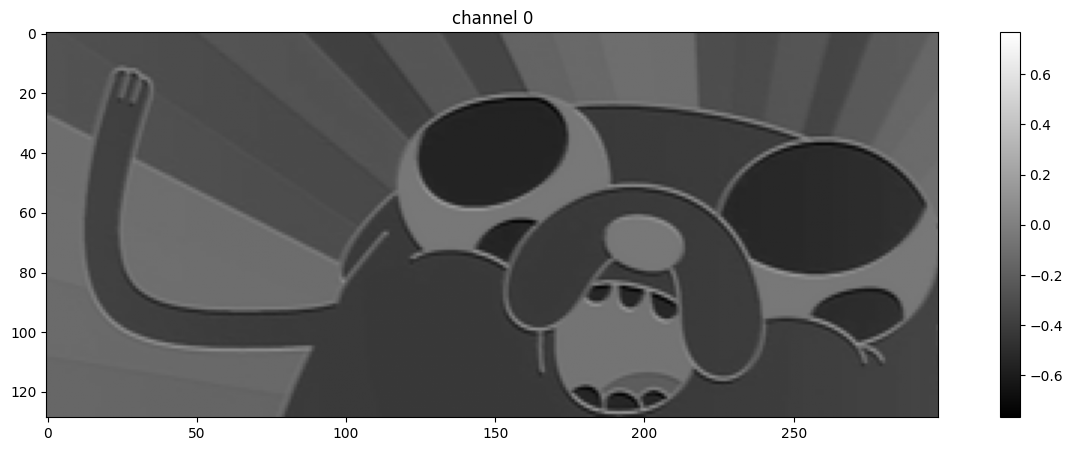

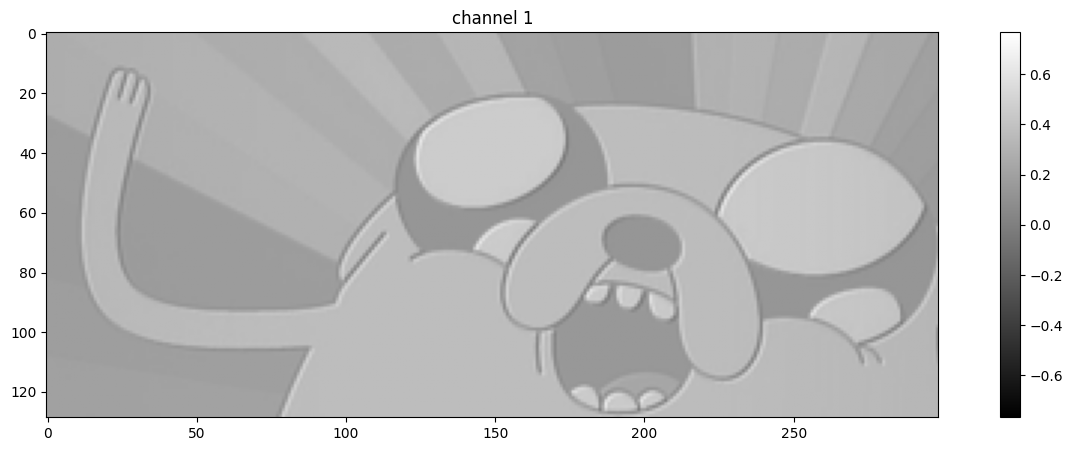

In [128]:
a = conv(x)
plot_channels(a[0], figsize=(16, 5))

Compute feature maps from the activation maps

tensor(0.6281, grad_fn=<MaxBackward1>)


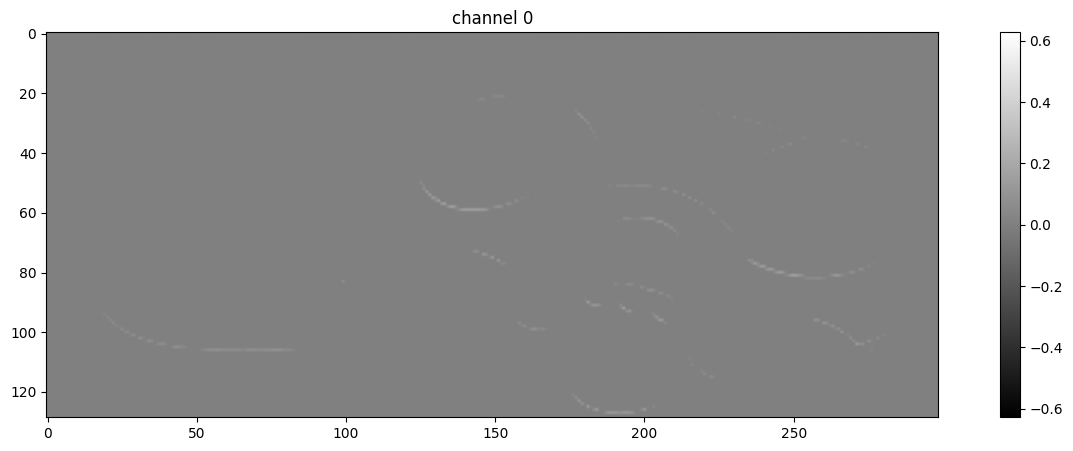

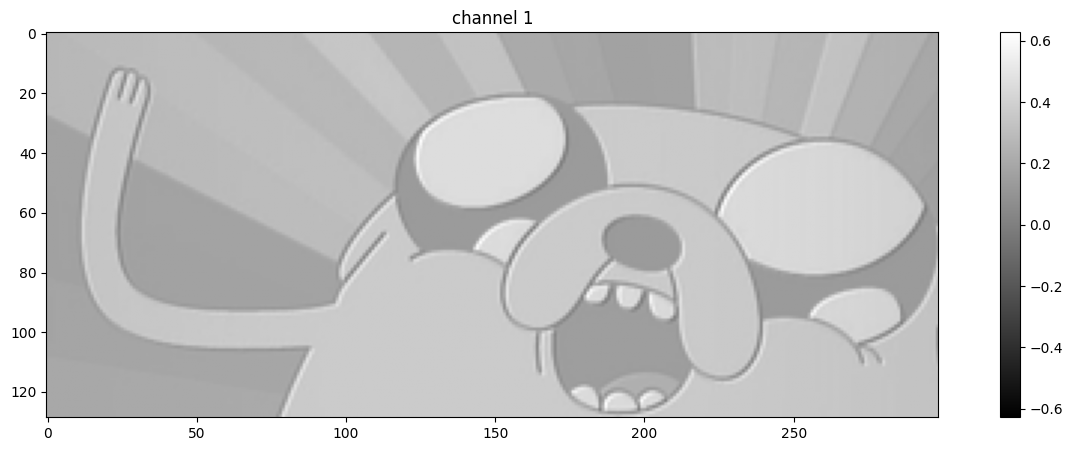

In [130]:
z = func(a)
plot_channels(z[0], figsize=(16, 5))

## **Compare running times (PyTorch vs pure Python)**

In [131]:
%time a = conv_py(x[0,0], w)   # Python (1 filter only)
%time a = conv(x)              # PyTorch (2 filters)

CPU times: user 4.71 s, sys: 0 ns, total: 4.71 s
Wall time: 4.78 s
CPU times: user 3.15 ms, sys: 0 ns, total: 3.15 ms
Wall time: 2.14 ms


## **Pooling in Python**

Max-pooling is common layer in convolutional architectures. It reduces the spatial resolution of a feature map, but tries to preserve the most highly active value (the maximal values) within each "pooling region".

In [132]:
def maxpool_py(x, s):
    """2D max pooling of x over a region size s with stride s."""
    xn, xm = x.shape
    an, am = (xn//s, xm//s)          # size of output feature map
    a = np.full((an, am), -np.inf, dtype=np.float32)
    for ai in range(an):             # loop over output row ai
        for aj in range(am):         # loop over output col aj
            for ri in range(s):      # loop over region row ri
                for rj in range(s):  # loop over region col rj
                    xi = ai*s + ri   # calculate input row xi
                    xj = aj*s + rj   # calculate input col xj
                    a[ai,aj] = max(a[ai,aj], x[xi,xj])  # contribute x[xi,xj] to a[ai,aj]
    return a

First, show the convolution from earlier as a reference, with non-overlapping 2x2 pooling regions plotted via a grid.

In [134]:
x = make_synthetic()
a = conv_py(x, w)

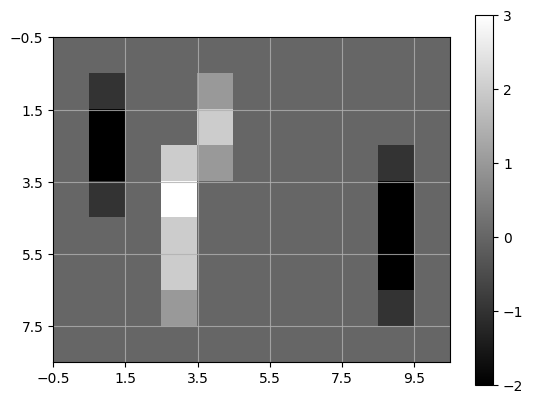

In [136]:
plt.imshow(a, vmin=-2, vmax=3,cmap='gray'); plt.colorbar();
plt.xticks(np.arange(0, a.shape[1], 2)-.5)
plt.yticks(np.arange(0, a.shape[0], 2)-.5)
plt.grid(True, alpha=0.8)

Show the result of max-pooling non-overlapping regions with a stride of 2

In [138]:
z = maxpool_py(a, 2)
z

array([[0., 0., 1., 0., 0.],
       [0., 2., 2., 0., 0.],
       [0., 3., 0., 0., 0.],
       [0., 2., 0., 0., 0.]], dtype=float32)

Plot the new (pooled) feature map as an image.

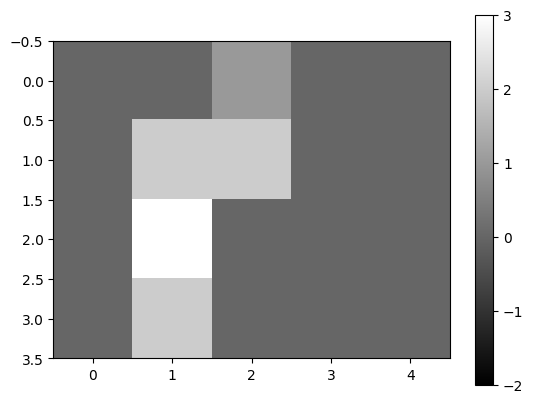

In [ ]:
plt.imshow(z, vmin=-2, vmax=3, cmap='gray'); plt.colorbar();

## **Pooling in PyTorch**

Show how to implement the same pooling operation, but with PyTorch.

In [139]:
pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

Pool the activation map directly, for simplicity.

In [140]:
x = hwc_to_nchw(torch.from_numpy(x))   # convert to PyTorch format
a = conv(x)                            # compute activation maps
z = func(a)                            # compute feature maps
z = pool(z)                            # compute pooled feature maps
z                                      # first should match Python version

tensor([[[[0.3236, 0.7351, 0.3672, 0.0000, 0.0000],
          [0.0554, 0.4706, 0.3709, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.2238, 0.2201, 0.2201, 0.2201]],

         [[0.1323, 0.1323, 0.1422, 0.1323, 0.1323],
          [0.1323, 0.5972, 0.7114, 0.5188, 0.5188],
          [0.1323, 0.8554, 0.4603, 0.4603, 0.4603],
          [0.1323, 0.6628, 0.4603, 0.4603, 0.4603]]]],
       grad_fn=<MaxPool2DWithIndicesBackward0>)

## **Convolve on audio**

Convolutional Neural Networks are used on audio signals as well.
They can be used on top of the raw waveforms directly (1D signal) or on top of 2D representations such as FBANKs or spectrograms.

### ***Convolution on Raw audio waveforms***

The raw audio waveform is simply a sequence of samples. It is a 1-dimensional signal and we can apply 1D convolution on top of it:



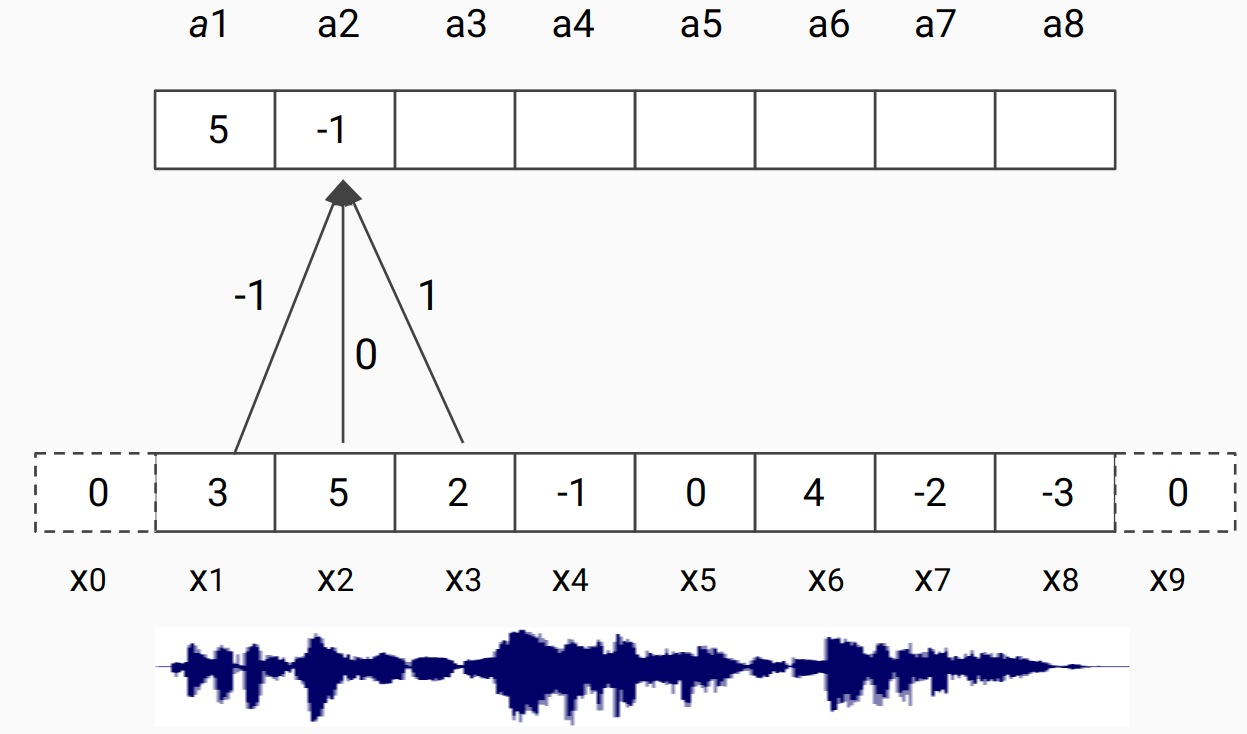

Let's download an audio signal:

In [141]:
!gdown 1kmavMXU1cYCGzh2mO5XaBSNG10lyaYzA

Downloading...
From: https://drive.google.com/uc?id=1kmavMXU1cYCGzh2mO5XaBSNG10lyaYzA
To: /content/test_sample.wav
100% 91.9k/91.9k [00:00<00:00, 72.5MB/s]


We now read the audio signal and play it.

In [153]:
import torchaudio
from IPython.display import Audio

# Reading the audio signal
sig, fs = torchaudio.load('test_sample.wav')

print(sig.shape)
Audio(sig.numpy(), rate=16000)


torch.Size([1, 45920])


We can initialize the Conv1D object with its hyperparameters. In this simple example, we use kernels with lengths 5 and 2 channels in output.

In [155]:
conv = torch.nn.Conv1d(in_channels=1, out_channels=2, kernel_size=5, stride=1, padding=0)

We manually plug-in two FIR filters to extract low and high frequencies, respectively.

In [156]:
conv.weight.data[0,:] = torch.tensor([[0.189555307858955052, 0.205173186750556485, 0.210543010780976952, 0.205173186750556485, 0.189555307858955052]]) # Low Pass Filter

conv.weight.data[1,:] = torch.tensor([[0.113897090485386598, -0.297627440470759286, 0.367460699970745375, -0.297627440470759286, 0.113897090485386598]]) # High Pass Filter

conv.bias.data[:] = 0

Now, let's apply the 1D convolution on top of our waveform:

In [157]:
out = conv(sig)
print(out.shape)

torch.Size([2, 45916])


We can play the results:

In [158]:
# This channel will emphasize the low frequencies.
Audio(out[0].detach().numpy(), rate=16000)


In [159]:
# This channel will emphasize the high frequencies.
Audio(out[1].detach().numpy(), rate=16000)

### ***Convolution on Spectrograms***

The spectrogram is a time-frequency representation of an audio signal. It is a 2-dimensional signal and you can consider it a kind of image. We can apply 2D convolution on top of it.

First, let's define a utility function for plotting the spectrogram:

In [160]:
import librosa
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

We can now initialize the object that will compute the spectrogram. We use 1024 FFT points with a hop length of 512 points.

In [161]:
n_fft = 1024
win_length = None
hop_length = 512

# Define transform
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

Let's now compute the spectrogram and plot it:

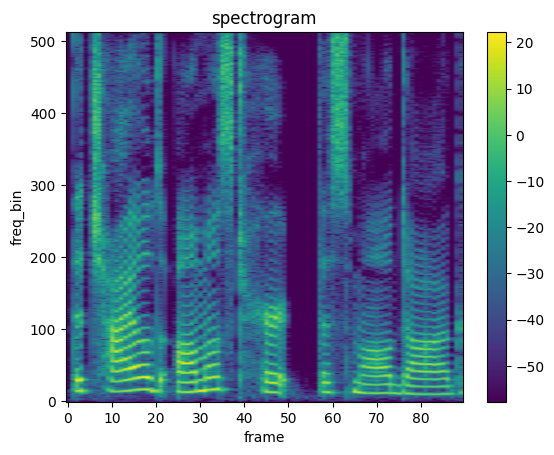

In [162]:
spec = spectrogram(sig)
plot_spectrogram(spec[0], title="spectrogram")

On top of the spectrogram, we will apply the following 2D convolution:

In [163]:
conv = torch.nn.Conv2d(in_channels=1, out_channels=2, kernel_size=2, stride=1, padding=0)

We manually plug in the following filters:

In [164]:
conv.weight.data[0,:] = torch.tensor([[[+1, +1],
                                       [+1, +1]]])

conv.weight.data[1,:] = torch.tensor([[[-1, -1],
                                       [+1, +1]]])

conv.bias.data[:] = 0

We can now apply the convolution and plot the results:

In [165]:
out = conv(spec)
print(out.shape)

torch.Size([2, 512, 89])


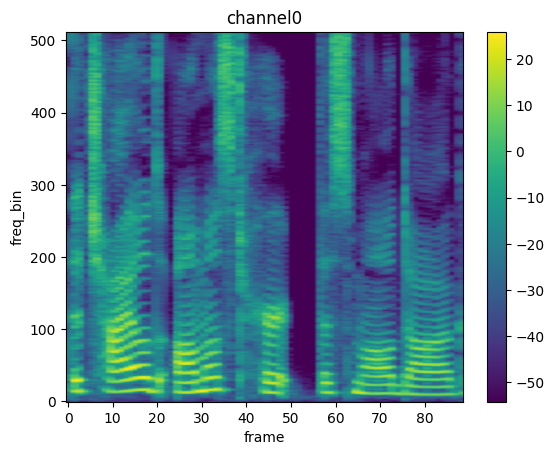

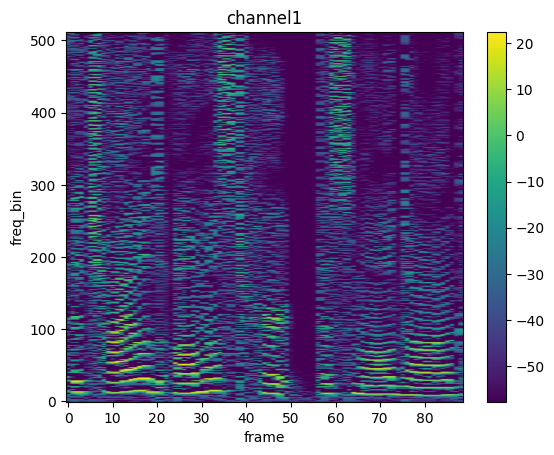

In [166]:
plot_spectrogram(out[0].detach(), title="channel0")
plot_spectrogram(out[1].detach(), title="channel1")

Also here, we can see in the output two different versions of the original spectrogram. In a real neural network, we learn the filters such that each channel captures some relevant information for the machine learning problem we want to solve.


*Do you think we can use 1D convolutions on top of the spectrogram?*

Using 2D convolutions seems a natural choice for capturing the local correlations in time and frequnecy. However, spectrograms, also contain long-term correlations in the frequency domain. To better visualize that, let's zoom in on a vowel:




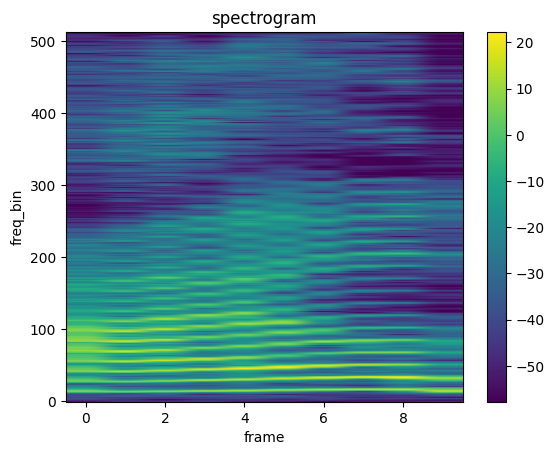

torch.Size([1, 513, 90])


In [169]:
plot_spectrogram(spec[0,:,10:20], title="spectrogram")
print(spec.shape)

You can see that there are spectral lines that are repeated multiple times over the frequency axis. These are the pitch, formats, and higher-order resonant frequencies of the vocal tract. This information is very relevant to perform tasks like speech recognition.

To capture them, a better option would be to use a 1D convolution that integrates over the entire frequency axis. Here is an example (with random filters):

torch.Size([1, 513, 90])
torch.Size([1, 2, 86])


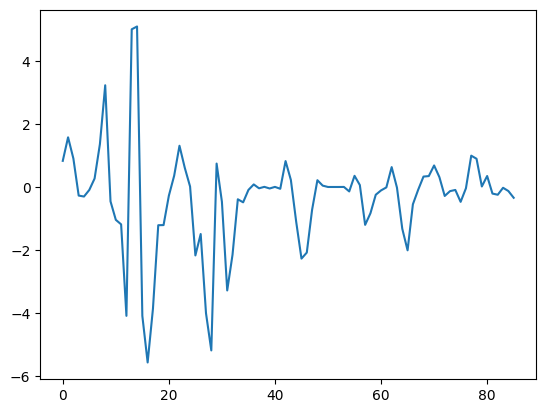

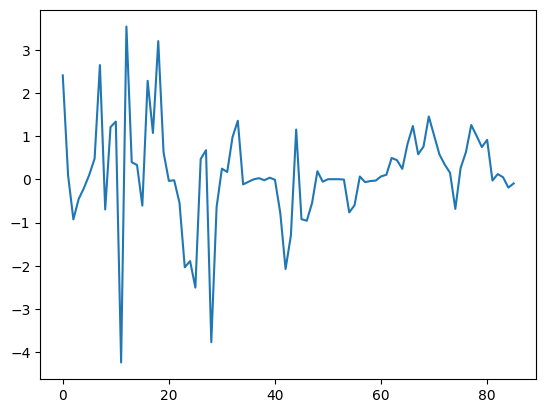

In [ ]:
conv = torch.nn.Conv1d(in_channels=513, out_channels=2, kernel_size=5, stride=1, padding=0)
out = conv(spec)

print(spec.shape)
print(out.shape)

plt.plot(out[0][0].detach())
plt.show()
plt.plot(out[0][1].detach())
plt.show()

This representation is not interpretable, but, when the network is trained properly, it can capture the long-term dependencies on the frequency axis.

Even though this approach sounds more principled than 2D convolutions,  using Conv2D works well in practice. You just need to employ multiple layers such that the receptive field increases on both the time and frequency axis.